# Accessing 3D Thermistor Array as NetCDF via OOI RESTful API
Here are some basic instructions to get started using the OOI M2M Web Services to request TMPSF (3D Thermistor Array) data

## Getting Started
* Create a user account on ooinet.oceanobservatories.org, or use the CILogon button with an academic or Google account
* Log in
* Navigate to the drop down menu screen in the top-right corner menu
* Click on the "User Profile" element of the drop down.
* Copy and save the following data from the user profile: API Username and API Token. The API Username is similar to “OOIAPI-QTULEV9STCAS55”. The API Token is similar to “YXP2Q2W4SOP”.

In [1]:
import requests
import time
from thredds_crawler.crawl import Crawl
import os
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
USERNAME ='YOUR-API-USER'
TOKEN= 'YOUR-API-TOKEN'
DATA_API_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

In this example we will request information and data from the Cabled Axial Seamount ASHES Vent Field (RS03ASHS) - Medium-Power JBox (MJ03B) - Diffuse Vent Fluid 3-D Temperature Array (07-TMPSFA301) sensor. 

Platform = RS03ASHS  
Node = MJ03B  
Instrument = 07-TMPSFA301  
Delivery Method = streamed  
Stream Name = tmpsf_sample  

Platform, Node, Instrument, Delivery Method and Stream Name can be found in the [OOI data catalog](https://ooinet.oceanobservatories.org/data_access). These are all elements necessary to build a data request url, which we will do in the next step. For this example, we will request all data between 2017-09-04T17:54:58.050Z and 2017-11-04T23:54:58.050Z.

In [3]:
data_request_url = DATA_API_BASE_URL+\
                    'RS03ASHS/'+\
                    'MJ03B/'+\
                    '07-TMPSFA301/'+\
                    'streamed/'+\
                    'tmpsf_sample?'+\
                    'beginDT=2017-09-04T17:54:58.050Z&'+\
                    'endDT=2017-09-11T23:54:58.050Z'

Next, let's send the data request. This will prompt the system to pull together raw data, asset information, and calibration values to generate the data products and package them up in a NetCDF file. This file will be returned on a THREDDS server, for which a URL will be provided in the response.

In [4]:
r = requests.get(data_request_url, auth=(USERNAME, TOKEN))
data = r.json()

The first URL in the 'allURLs' key is the THREDDS server, which allows for programmatic data access without downloading the entire file. We will get to that.

In [5]:
print(data['allURLs'][0])

https://opendap.oceanobservatories.org/thredds/catalog/ooi/friedrich.knuth@rutgers.edu/20171113T222751-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/catalog.html


The second URL in the 'allURLs' key is the direct download server. We can use this URL to check if a `status.txt` file has been written to the location. If true, then the request has completed and all data have been delivered to the THREDDS server.

In [6]:
print(data['allURLs'][1])

https://opendap.oceanobservatories.org/async_results/friedrich.knuth@rutgers.edu/20171113T222751-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample


The following for loop will poll the location for the status.txt files 1000 times, once every 0.5 seconds. Therefore, it will quit after about 8.3 minutes. If you are requesting a very large and dense dataset (3 years of BOTPT data collected at 20 Hz, for example), it may take a bit longer to complete the request, so you will want to bump up the retry range or lower the sleep interval.

In [7]:
%%time

check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1000): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(.5)  

request completed
CPU times: user 1.78 s, sys: 130 ms, total: 1.91 s
Wall time: 1min


Now let's go back to that first URL and grab the URL for the NetCDF file dataset from THREDDS.

In [8]:
url = data['allURLs'][0]
url = url.replace('.html', '.xml')
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
c = Crawl(url, select=[".*\.nc$"], debug=False)
datasets = [os.path.join(tds_url, x.id) for x in c.datasets]
splitter = url.split('/')[-2].split('-')
dataset_url = datasets[0]

Finally, we can load the dataset directly into memory using xarray and plot the data.

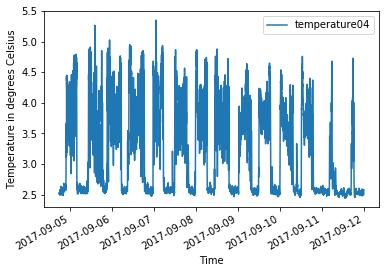

In [9]:
ds = xr.open_dataset(dataset_url)
ds = ds.swap_dims({'obs': 'time'})
ds['temperature04'].plot.line()
plt.ylabel('Temperature in degrees Celsius')
plt.xlabel('Time')
plt.legend()
plt.show()